In [182]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
import torch

from matplotlib import cm
from matplotlib.ticker import LinearLocator

from mpl_toolkits.mplot3d import axes3d


In [183]:
# | export


def complex_oscillator_exp(
    z: torch.ComplexType,
    initial_phase: torch.ComplexType = None,
    N: int = 2048,
    constrain: bool = False,
    reduce: bool = False,
):
    """Generates an exponentially decaying sinusoid from a complex number."""

    if initial_phase is None:
        # If no initial phase is provided, use zero phase.
        # Note that in the complex representation, zero phase is equivalent to a real number.
        initial_phase = torch.ones_like(z)
    
    if constrain:
        # Limit the magnitude of z to 1. Note that tanh is used in lieu of sigmoid to 
        # avoid vanishing gradients as magnitude approaches zero.
        mag = torch.abs(z)
        z = z * torch.tanh(mag) / mag

    z = z[..., None].expand(*z.shape, N - 1)
    z = torch.cat([initial_phase.unsqueeze(-1), z], dim=-1)
    
    y = z.cumprod(dim=-1)

    if reduce:
        y = y.sum(dim=-2)

    return y

def mseloss(predicted_signal,target_signal):
    criterion = torch.nn.MSELoss()
    loss = criterion(torch.real(predicted_signal), torch.real(target_signal)) + criterion(torch.imag(predicted_signal), torch.imag(target_signal))-1
    return loss

def mixingloss(predicted_signal,target_signal):
    criterion = torch.nn.MSELoss()
    mixed_signal = predicted_signal * (1/target_signal)
    loss = criterion(torch.real(mixed_signal),torch.ones(target_signal.shape)) + criterion(torch.imag(mixed_signal),torch.zeros(target_signal.shape))
    return loss

## Loss visualisation for full sampling

torch.Size([100, 100])


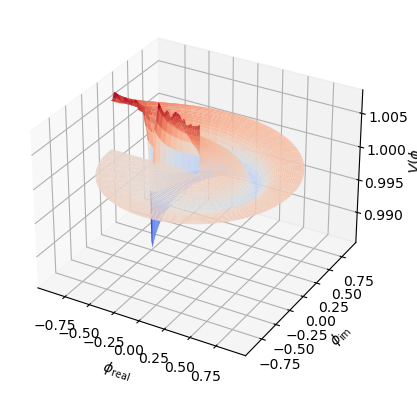

In [184]:
N = 1024
n = np.arange(N)


target_freq = torch.tensor(0.1) * pi

sig = 0.5
target_signal = 0.9*torch.exp(1j*target_freq * n) + sig**2/2 * torch.complex(torch.randn(n.shape),torch.randn(n.shape))


rrange = torch.linspace(0,0.9,100)
thetarange = torch.linspace(-1,1,100) * pi

mse = torch.zeros((rrange.shape[0],thetarange.shape[0]))
mixloss = torch.zeros((rrange.shape[0],thetarange.shape[0]))

for a in range(rrange.shape[0]):
    for b in range(thetarange.shape[0]):
        predicted_z = rrange[a]*torch.exp(1j * thetarange[b])  #torch.exp(1j * thetarange[i])
        predicted_signal = (complex_oscillator_exp(predicted_z, N=N))
        mse[a,b] = mseloss(predicted_signal,target_signal)
        mixloss[a,b] = mixingloss(predicted_signal,target_signal)


X, Y = np.meshgrid(thetarange, rrange)
Z = mixloss

print(Z.shape)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

R,P = np.meshgrid(rrange,thetarange)

X,Y = R*np.cos(P), R*np.sin(P)

ax.plot_surface(X,Y,Z,cmap = cm.coolwarm)

ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi$')

plt.show()

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
## Plot the surface.
#surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#
## Customize the z axis.
##ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
## A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#
## Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#
#plt.show()



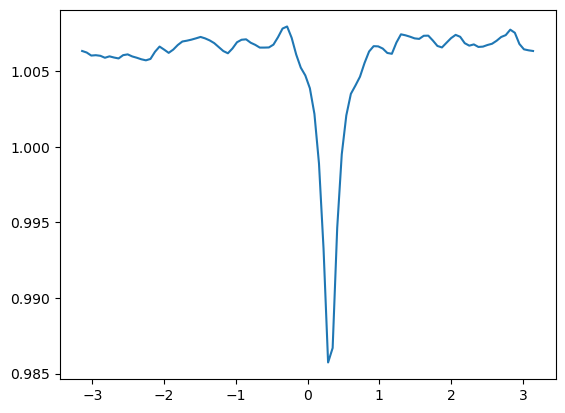

In [185]:
plt.plot(thetarange,Z[-1,:])
plt.show()

## Loss visualisation for random undersampling

torch.float64
torch.float64 torch.float64
torch.Size([1024]) torch.Size([1024])


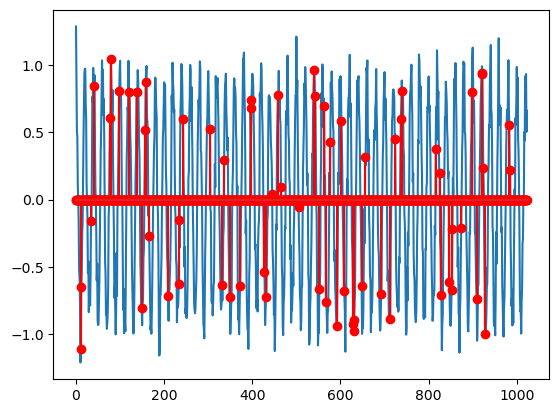

In [186]:
M = 64

idx = np.sort(np.random.choice(np.arange(N),(M,),replace=False))


sampling_vector = torch.zeros((N,),dtype=torch.float64)
print(sampling_vector.dtype)
sampling_vector[idx] = 1

sampling_matrix = torch.diag(sampling_vector)


print(sampling_matrix.dtype,torch.real(target_signal.unsqueeze(1)).dtype)

randomly_sampled_signal = torch.complex(sampling_matrix @ torch.real(target_signal.unsqueeze(1)),sampling_matrix @ torch.imag(target_signal.unsqueeze(1)))

print(randomly_sampled_signal.squeeze().shape,target_signal.shape)
plt.plot(torch.real(target_signal))
plt.stem(torch.real(randomly_sampled_signal.squeeze()),'r')
plt.show()

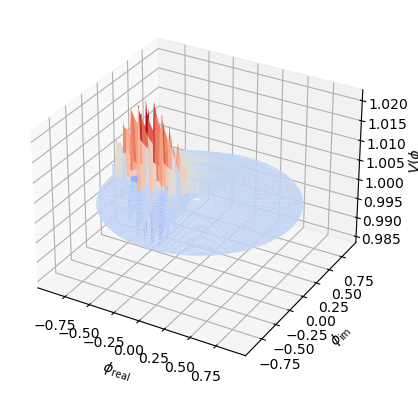

In [187]:
mse = torch.zeros((rrange.shape[0],thetarange.shape[0]))

for a in range(rrange.shape[0]):
    for b in range(thetarange.shape[0]):
        predicted_z = rrange[a]*torch.exp(1j * thetarange[b])  #torch.exp(1j * thetarange[i])
        predicted_signal = (complex_oscillator_exp(predicted_z, N=N))
        mse[a,b] = mseloss(predicted_signal[idx],target_signal[idx])
        mixloss[a,b] = mixingloss(predicted_signal[idx],target_signal[idx])

X, Y = np.meshgrid(thetarange, rrange)
Z = mixloss

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

R,P = np.meshgrid(rrange,thetarange)

X,Y = R*np.cos(P), R*np.sin(P)

ax.plot_surface(X,Y,Z,cmap = cm.coolwarm)

ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi$')

plt.show()

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
## Plot the surface.
#surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#
## Customize the z axis.
##ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
## A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#
## Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#
#plt.show()

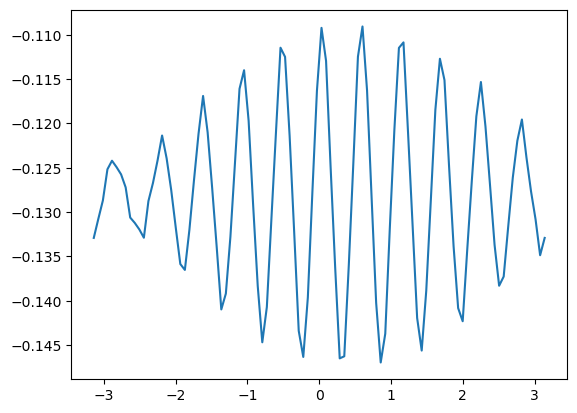

In [188]:
plt.plot(thetarange,mse[-1,:])
plt.show()

## Loss function visualisation for random demodulation

In [189]:
def random_demod(x,K):
    """
    Return a measurement of the target signal by a random modulator
    Inputs:
        - x, full signal to be sampled
        - K, reduction factor required
    Outputs:
        - ym, measured signal/vector
        - Theta, measurement matrix
    """

    # Generate random PRBS signal
    prbs = 2*torch.randint(0,2,x.shape)-np.ones(x.shape)
    # Generate integration matrix
    N = x.shape[0]
    h = torch.ones((1,K),dtype=torch.float64)
    H = torch.zeros((int(N/K),N),dtype=torch.float64)
    for i in range(H.shape[0]):
        H[i,i*K:(i+1)*K] = h



    # Construct the sensing matrix
    P = torch.diag(prbs)

    Theta = H @ P
    

    # Sense the signal 

    ym = Theta @ torch.real(x) + 1j* (Theta @ torch.imag(x))
    
    return ym, Theta

torch.Size([64])


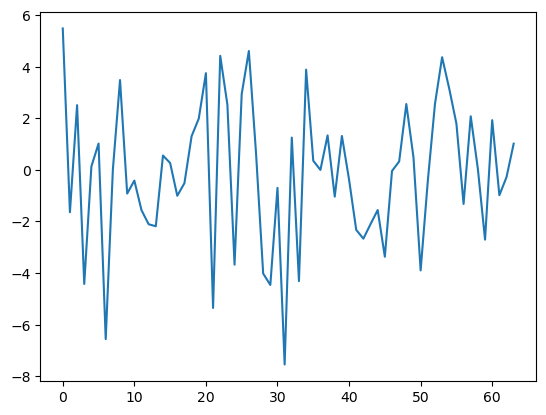

In [190]:
K = int(N/M)
ym, Theta = random_demod(target_signal,K)

print(ym.shape)
plt.plot(ym)
plt.show()

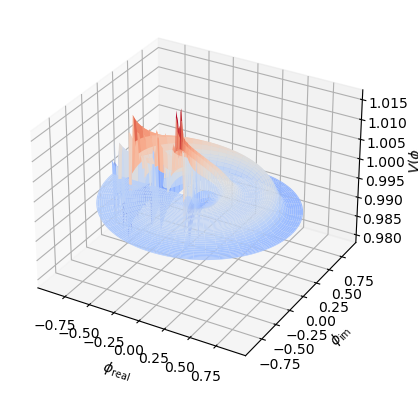

In [191]:
mse = torch.zeros((rrange.shape[0],thetarange.shape[0]))

for a in range(rrange.shape[0]):
    for b in range(thetarange.shape[0]):
        predicted_z = rrange[a]*torch.exp(1j * thetarange[b])  #torch.exp(1j * thetarange[i])
        predicted_signal = (complex_oscillator_exp(predicted_z, N=N)).to(torch.complex128)
        sampled_predicted_signal = Theta @ torch.real(predicted_signal) + 1j* (Theta @ torch.imag(predicted_signal))
        mse[a,b] = mseloss(sampled_predicted_signal,ym)
        mixloss[a,b] = mixingloss(sampled_predicted_signal,ym)

X, Y = np.meshgrid(thetarange, rrange)
Z = mixloss

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

R,P = np.meshgrid(rrange,thetarange)

X,Y = R*np.cos(P), R*np.sin(P)

ax.plot_surface(X,Y,Z,cmap = cm.coolwarm)

ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi$')

plt.show()

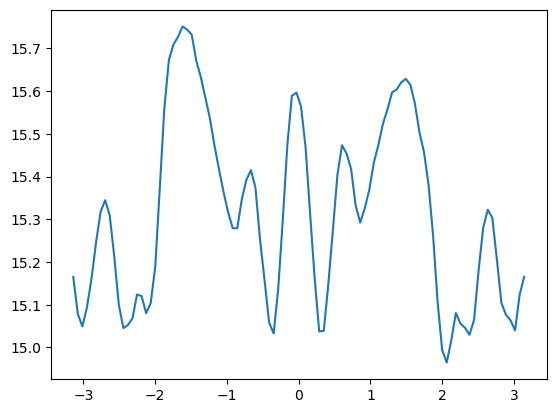

In [192]:
plt.plot(thetarange,mse[-1,:])
plt.show()

## Conclusions

- Random modulator seems to stabilise the loss function, as compared to random sampling